# **Chapter 3: Multiple-Subject Analysis**

***

In this section on multisubject analysis, , it is divided into the following 3 parts：

- **Part 1: Batch Processing for Reading and Storing Demo Data**
- **Part 2: Event-Related Potential Analysis**  
- **Part 3: Time-Frequency Analysis**

## Download & Import Python packages we will use

In [1]:
! pip install gdown

import numpy as np
import os
import gdown
import zipfile
import h5py
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, ttest_rel
from mne.stats import fdr_correction, f_mway_rm
from neurora.stuff import clusterbased_permutation_1d_1samp_1sided, permutation_test, \
                          clusterbased_permutation_2d_1samp_2sided, \
                          clusterbased_permutation_2d_2sided
from mne.time_frequency import tfr_array_morlet

# Part 1 Batch Processing for Reading and Storing Demo Data

### **Preprocessed Demo Data 1**：  
（You will use it in Part 2和Part 3）  
The original dataset is based on the article "A multi-subject, multi-modal human neuroimaging dataset" by Wakeman & Henson, published in Scientific Data in 2015. In this experiment, there are three types of faces: familiar faces, unfamiliar faces, and scrambled faces, with 150 images for each type, totaling 450 stimulus images. Participants wore an EEG cap to perform a simple perceptual task, which included an unpredictable stimulus phase of 800-1000ms, a delay of 1700ms, and an inter-trial interval (ITI) of 400-600ms. Each image was viewed twice; for the second viewing, 50% of the stimulus images might be the same image immediately following the first viewing, while the other 50% were presented after several other trials. Here, only the EEG data from the first eight subjects who viewed multiple familiar face images for the first time and then immediately viewed some of these images again in the next trial are extracted.

In [2]:
# Download Demo Data 1

data_dir = "data/"
if not os.path.exists(data_dir):
  os.makedirs(data_dir)

url = "https://drive.google.com/file/d/1hsPmIFod3c7ZR0YdyO8woqUfqO_3pZtR/view?usp=sharing"
filename = "demo_data1"
filepath = data_dir + filename + ".zip"

# Download the data
gdown.download(url=url, output=filepath, quiet=False, fuzzy=True)
print("Download completes!")
# unzip the data
with zipfile.ZipFile(filepath, 'r') as zip:
    zip.extractall(data_dir)
print("Unzip completes!")

Downloading...
From (original): https://drive.google.com/uc?id=1hsPmIFod3c7ZR0YdyO8woqUfqO_3pZtR
From (redirected): https://drive.google.com/uc?id=1hsPmIFod3c7ZR0YdyO8woqUfqO_3pZtR&confirm=t&uuid=e8de1cf4-e55e-4d41-9c7d-9075412ae979
To: /Users/zitonglu/Downloads/Python-EEG-Handbook-master/data/demo_data1.zip
100%|████████████████████████████████████████| 242M/242M [00:32<00:00, 7.40MB/s]


Download completes!
Unzip completes!


Taking sub1 as an example, 'sub1_first.mat' contains EEG data for the first viewing of familiar face images, and 'sub1_rep.mat' contains EEG data for the immediate second viewing of familiar faces. The number of trials in the former case is double that of the latter. The data has been preprocessed (0.1-30Hz filtering) and segmented. The data includes 74 channels (of which 70 are EEG channels, with channels 61, 62, 63, and 64 being eye movement channels) and a sampling rate of 250Hz. Each trial covers from 0.5 seconds before to 1.5 seconds after the stimulus presentation, with 500 time points per trial.

### Batch Processing to Read Demo Data 1 and Save as a .h5 File

In [3]:
# Iterate over the data of 8 subjects
for sub in range(8):

    # Get the paths of .mat files for the two conditions of each subject
    subdata_first_path = 'data/demo_data1/sub' + str(sub + 1) + '_first.mat'
    subdata_rep_path = 'data/demo_data1/sub' + str(sub + 1) + '_rep.mat'

    # Extract data from the .mat files
    # subdata shape: [n_channels, n_times, n_trials]
    subdata_first = sio.loadmat(subdata_first_path)['data']
    subdata_rep = sio.loadmat(subdata_rep_path)['data']

    # Delete four EOG channels
    subdata_first = np.delete(np.array(subdata_first), [60, 61, 62, 63], axis=0)
    subdata_rep = np.delete(np.array(subdata_rep), [60, 61, 62, 63], axis=0)

    # Print the subject number and the shape of EEG matrices for two conditions:
    # first viewing of familiar faces and immediate repeated viewing
    print('sub' + str(sub + 1))
    print(subdata_first.shape)
    print(subdata_rep.shape)

    # Store the EEG data (in matrix form) for the two stimulus conditions of each subject
    # in an .h5 file with 'data' and 'data_rep' as Keys
    f = h5py.File('data/demo_data1/sub' + str(sub + 1) + '.h5', 'w')
    f.create_dataset('data_first', data=subdata_first)
    f.create_dataset('data_rep', data=subdata_rep)
    f.close()

sub1
(70, 500, 150)
(70, 500, 78)
sub2
(70, 500, 150)
(70, 500, 79)
sub3
(70, 500, 150)
(70, 500, 74)
sub4
(70, 500, 150)
(70, 500, 68)
sub5
(70, 500, 150)
(70, 500, 67)
sub6
(70, 500, 150)
(70, 500, 70)
sub7
(70, 500, 150)
(70, 500, 77)
sub8
(70, 500, 150)
(70, 500, 70)


# Part 2 Event-Related Potential Analysis

#### Here, we will use Demo Data 1 as an example.   
##### We will visualize the ERP results and conduct statistical analyses for two conditions in the experiment, the first viewing of familiar faces and the immediate repeated viewing of familiar faces, respectively.

### Read Data and Average Epoches

In the example below, the ERP from the 50th channel is taken as an example, selecting the time-window from -200ms to 1000ms.

In [4]:
# Initialize two variables to store the ERP for each subject under the two conditions
# 8 - n_subjects, 300 - n_times (from -200ms to 1000ms)
erp_first = np.zeros([8, 300])
erp_rep = np.zeros([8, 300])

# Iterate over each subject
for sub in range(8):

    # Read the data for this subject
    with h5py.File('data/demo_data1/sub' + str(sub + 1) + '.h5', 'r') as f:
        subdata_first = np.array(f['data_first'])
        subdata_rep = np.array(f['data_rep'])
        f.close()
    # The shape of subdata and subdata_rep is [n_channels, n_times, n_trials]

    # Select data from the 50th electrode, average across trials, and take -200ms to 1000ms
    erp_first[sub] = np.average(subdata_first[49], axis=1)[75:375]
    erp_rep[sub] = np.average(subdata_rep[49], axis=1)[75:375]

    # Baseline correction, using the baseline from -100 to 0ms
    erp_first[sub] = erp_first[sub] - np.average(erp_first[sub, 25:50])
    erp_rep[sub] = erp_rep[sub] - np.average(erp_rep[sub, 25:50])

### Statistical Analyses and Visualization

#### Define a function to plot ERP results - plot_erp_results()

In [5]:
def plot_erp_results(erp, times, ylim=[-10, 10], labelpad=0):

    """
    parameters：
        erp: a matrix with the shape [n_subs, n_times] corresponding to all subjects' ERPs
        times: a array with the shape [n_times] corresponding to the time-points and the range of x-axis
        ylim: the lims of y-axis, default [-10, 10]
        labelpad : a int value, spacing in points from the axes, default 0
    """

    n_subjects = np.shape(erp)[0]

    # averaging the ERPs
    avg = np.average(erp, axis=0)
    # calcualte the SEM for each time-point
    err = np.std(erp, axis=0, ddof=0)/np.sqrt(n_subjects)
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))

    # plot the ERP
    plt.fill_between(times, avg+err, avg-err, alpha=0.2)
    plt.plot(times, avg, alpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel(r'Amplitude in $\mu$V', fontsize=16, labelpad=labelpad)
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylim(ylim[0], ylim[1])
    plt.show()

#### Plot the ERP under the condition of the first viewing of familiar faces

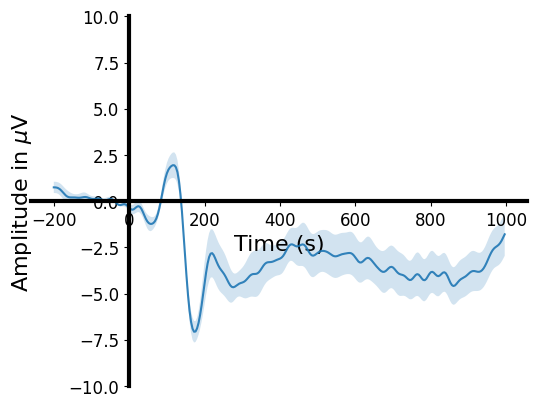

In [6]:
times = np.arange(-200, 1000, 4)
plot_erp_results(erp_first, times, labelpad=25)

#### Plot the ERP under the condition of the immediate repeated viewing of familiar faces

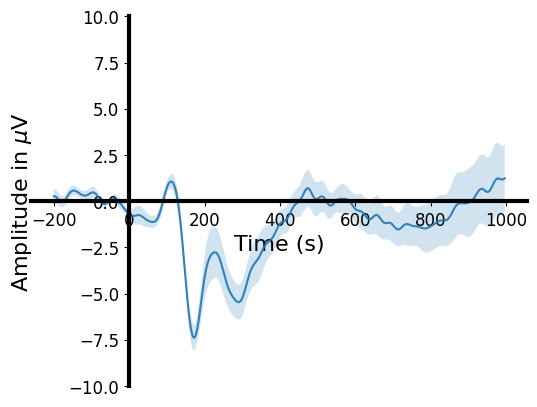

In [7]:
plot_erp_results(erp_rep, times, labelpad=25)

#### Define a function to visualize joint ERPs for two conditions together - plot_erp_2cons_results()   

In [8]:
def plot_erp_results(erp1, erp2, times, con_labels=['Condition1', 'Condition2'], ylim=[-10, 10],
                     p_threshold=0.05, labelpad=0):

    """
    parameters：
        erp1: a matrix with the shape [n_subs, n_times] corresponding to all subjects' ERPs under condition 1
        erp2: a matrix with the shape [n_subs, n_times] corresponding to all subjects' ERPs under condition 2
        times: an array with the shape [n_times] corresponding to the time-points and the range of x-axis
        con_labels: a list or array with the labels of two conditions, default ['Condition 1', 'Condition 2']
        ylim: the lims of y-axis, default [-10, 10]
        p_threshold : a float value, default is 0.05, representing the threshold of p-value
        labelpad : a int value, spacing in points from the axes, default 0
    """

    n_subjects = np.shape(erp1)[0]

    # averaging the ERPs
    avg1 = np.average(erp1, axis=0)
    avg2 = np.average(erp2, axis=0)
    # calcualte the SEM for each time-point
    err1 = np.std(erp1, axis=0, ddof=0)/np.sqrt(n_subjects)
    err2 = np.std(erp2, axis=0, ddof=0)/np.sqrt(n_subjects)

    # statistical analysis
    t_vals, p_vals = ttest_rel(erp1, erp2, axis=0)
    # FDR-correction
    # rejects, p_fdr_corrected = fdr_correction(p_vals, alpha=p_threshold)
            
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))
    
    # highlight the significant time-windows
    tstep = (times[-1]-times[0])/len(times)
    for i, p_val in enumerate(p_vals):
        if p_val < 0.05:
            plt.fill_between([times[i], times[i]+tstep], [ylim[1]], [ylim[0]], facecolor='gray', alpha=0.1)

    # plot the ERPs with statistical results
    plt.fill_between(times, avg1+err1, avg1-err1, alpha=0.2, label=con_labels[0])
    plt.fill_between(times, avg2+err2, avg2-err2, alpha=0.2, label=con_labels[1])
    plt.plot(times, avg1, alpha=0.9)
    plt.plot(times, avg2, alpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(ylim[0], ylim[1])
    plt.ylabel(r'Amplitude in $\mu$V', fontsize=16, labelpad=labelpad)
    plt.xlabel('Time (s)', fontsize=16)

    plt.legend()
    plt.show()

#### Plot the joint ERP results under two conditions

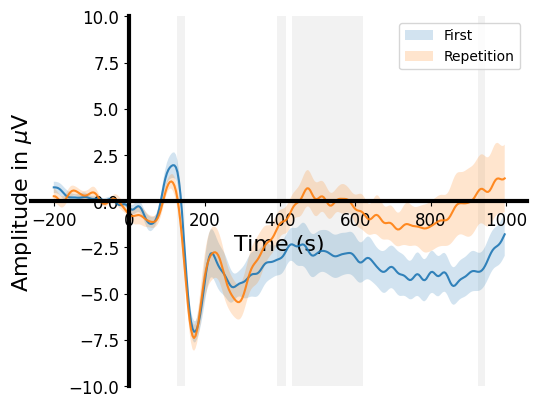

In [9]:
plot_erp_results(erp_first, erp_rep, times, con_labels=['First', 'Repetition'],
                 p_threshold=0.05, labelpad=25)

# Part 3 Time-Frequency Analysis

#### Here, we will also use Demo Data 1 as an example.   
##### We will visualize the time-frequency results and conduct statistical analyses for two conditions in the experiment, the first viewing of familiar faces and the immediate repeated viewing of familiar faces, respectively.

### Read Data and Conduct the Time-Frequency Analysis

In [10]:
# Initialize two variables to store the time-frequency analysis results for each subject under two conditions
# 8 - n_subjects, 70 - n_channels, 14 - n_freqs, 500 - n_times
tfr_first = np.zeros([8, 70, 14, 500])
tfr_rep = np.zeros([8, 70, 14, 500])

# Iterate over each subject
for sub in range(8):

    # Read the data for this subject
    with h5py.File('data/demo_data1/sub' + str(sub + 1) + '.h5', 'r') as f:
        subdata_first = np.array(f['data_first'])
        subdata_rep = np.array(f['data_rep'])
        f.close()
    # Transform the data shape from [n_channels, n_times, n_trials] to [n_trials, n_channels, n_times]
    subdata_first = np.transpose(subdata_first, (2, 0, 1))
    subdata_rep = np.transpose(subdata_rep, (2, 0, 1))

    # Set some parameters for time-frequency analysis
    # Select frequency band from 4-30Hz
    freqs = np.arange(4, 32, 2)
    n_cycles = freqs / 2.
    # Time-frequency analysis
    # Use the tfr_array_morlet() function from MNE's time_frequency module
    # The input is an array of shape [n_epochs, n_channels, n_times]
    # Followed by the sampling rate of the data, the frequencies to be computed, the number of cycles, and the output data type
    subtfr_first = tfr_array_morlet(subdata_first, 250, freqs, n_cycles, output='power')
    subtfr_rep = tfr_array_morlet(subdata_rep, 250, freqs, n_cycles, output='power')
    # The returned tfr shape is [n_trials, n_channels, n_freqs, n_times]
    # Here, average across the trials and channels dimensions and store into the tfr or tfr_rep variable
    tfr_first[sub] = np.average(subtfr_first, axis=0)
    tfr_rep[sub] = np.average(subtfr_rep, axis=0)
    # Baseline correction, using the 'logratio' method, i.e., divide by the baseline mean and take the log
    # The baseline is taken from -100 to 0ms
    for chl in range(70):
        for freq in range(len(freqs)):
            tfr_first[sub, chl, freq] = 10 * np.log10(tfr_first[sub, chl, freq] /
                                  np.average(tfr_first[sub, chl, freq, 100:125]))
            tfr_rep[sub, chl, freq] = 10 * np.log10(tfr_rep[sub, chl, freq] /
                                      np.average(tfr_rep[sub, chl, freq, 100:125]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Here, the time-frequency analysis results from -200ms to 1000ms for the 50th channel under both conditions will be used as an example for subsequent statistical analysis and visualization.

In [11]:
tfr_first_No50 = tfr_first[:, 49, :, 75:375]
tfr_rep_No50 = tfr_rep[:, 49, :, 75:375]

### Statistical Analyses and Visualization

#### Define a function to plot time-frequency analysis for a single condition - plot_tfr_results().  
This includes functionalities for statistical analysis and visualization, and the results undergo a cluster-based permutation test.

In [12]:
def plot_tfr_results(tfr, freqs, times, p=0.01, clusterp=0.05, clim=[-4, 4]):

    """
    Parameters:
        tfr : A matrix with shape [n_subs, n_freqs, n_times], representing the results of the time-frequency analysis
        freqs : An array with shape [n_freqs], representing the frequencies for the time-frequency analysis (corresponding to the frequency range and points on the y-axis)
        times : An array with shape [n_times], representing the time points for the time-frequency analysis (corresponding to the time range and points on the x-axis)
        p : A floating-point number, default is 0.01, representing the threshold for the p-value
        clusterp : A floating-point number, default is 0.05, representing the threshold for the cluster-level p-value
        clim : A list or array, [minimum, maximum], default is [-4, 4], representing the upper and lower boundaries of the color bar
    """

    n_freqs = len(freqs)
    n_times = len(times)

    # Statistical analysis
    # Note: Since a cluster-based permutation test is performed, it requires a longer runtime
    # Here, the clusterbased_permutation_2d_1samp_2sided() function from the NeuroRA's stuff module is used
    # The returned stats_results is a matrix with shape [n_freqs, n_times]
    # In this matrix, non-significant points have a value of 0, significant points greater than 0 have a value of 1, and significant points less than 0 have a value of -1
    # Here, iter is set to 100 for faster demonstration purposes, but 1000 is recommended
    stats_results = clusterbased_permutation_2d_1samp_2sided(tfr, 0,
                                                        p_threshold=p,
                                                        clusterp_threshold=clusterp,
                                                        iter=100)

    # Visualization of time-frequency analysis results
    fig, ax = plt.subplots(1, 1)
    # Outline the significant areas
    padsats_results = np.zeros([n_freqs + 2, n_times + 2])
    padsats_results[1:n_freqs+1, 1:n_times + 1] = stats_results
    x = np.concatenate(([times[0]-1], times, [times[-1]+1]))
    y = np.concatenate(([freqs[0]-1], freqs, [freqs[-1]+1]))
    X, Y = np.meshgrid(x, y)
    ax.contour(X, Y, padsats_results, [0.5], colors="red", alpha=0.9,
               linewidths=2, linestyles="dashed")
    ax.contour(X, Y, padsats_results, [-0.5], colors="blue", alpha=0.9,
               linewidths=2, linestyles="dashed")
    # Draw the heatmap of time-frequency results
    im = ax.imshow(np.average(tfr, axis=0), cmap='RdBu_r', origin='lower',
                   extent=[times[0], times[-1], freqs[0], freqs[-1]], clim=clim)
    ax.set_aspect('auto')
    cbar = fig.colorbar(im)
    cbar.set_label('dB', fontsize=12)
    ax.set_xlabel('Time (ms)', fontsize=16)
    ax.set_ylabel('Frequency (Hz)', fontsize=16)
    plt.show()

In [13]:
print(tfr_first.shape)

(8, 70, 14, 500)


#### Plot the time-frequency result under the condition of the first viewing of familiar faces


Permutation test

Side 1 begin:
Calculating: [====================================================================================================] 100.00%
Side 1 finished!

Side 2 begin:

Calculating: [====================================================================================================] 100.00%
Side 2 finished!

Cluster-based permutation test finished!



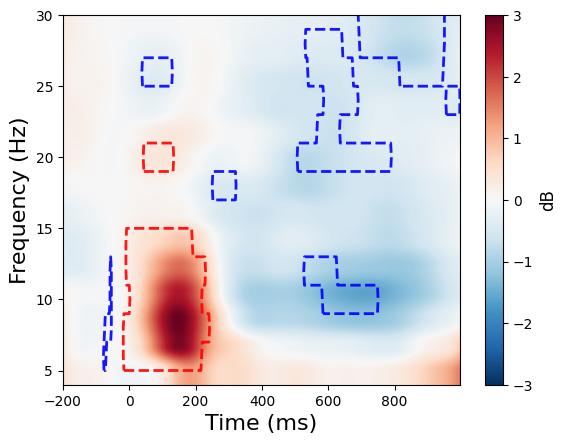

In [14]:
freqs = np.arange(4, 32, 2)
times = np.arange(-200, 1000, 4)
plot_tfr_results(tfr_first_No50, freqs, times, p=0.05, clusterp=0.05, clim=[-3, 3])

#### Plot the time-frequency result under the condition of the immediate repeated viewing of familiar faces


Permutation test

Side 1 begin:
Calculating: [====================================================================================================] 100.00%
Side 1 finished!

Side 2 begin:

Calculating: [====================================================================================================] 100.00%
Side 2 finished!

Cluster-based permutation test finished!



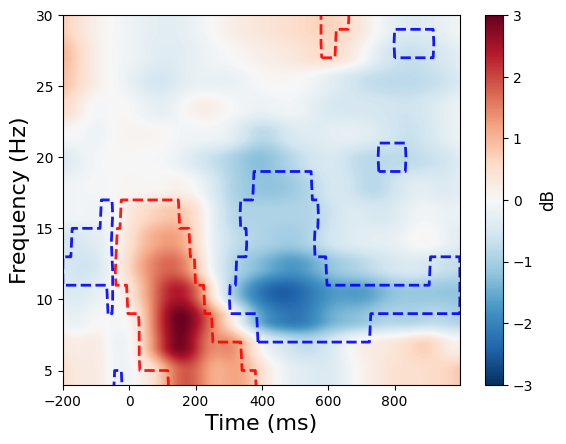

In [15]:
plot_tfr_results(tfr_rep_No50, freqs, times, p=0.05, clusterp=0.05, clim=[-3, 3])

#### Define a function to plot the difference of time-frequency results between two conditions - plot_tfr_diff_results()  
we calculate the difference by tfr1 - tfr2   
This includes functionalities for statistical analysis and visualization, and the results undergo a cluster-based permutation test.

In [16]:
def plot_tfr_diff_results(tfr1, tfr2, freqs, times, p=0.01, clusterp=0.05,
                          clim=[-2, 2]):

    """
    Parameters:
        tfr1 : A matrix with shape [n_subs, n_freqs, n_times], representing the time-frequency analysis results under condition 1
        tfr2 : A matrix with shape [n_subs, n_freqs, n_times], representing the time-frequency analysis results under condition 2
        freqs : An array with shape [n_freqs], representing the frequencies for the time-frequency analysis (corresponding to the frequency range and points on the y-axis)
        times : An array with shape [n_times], representing the time points for the time-frequency analysis (corresponding to the time range and points on the x-axis)
        p : A floating-point number, default is 0.01, representing the threshold for the p-value
        clusterp : A floating-point number, default is 0.05, representing the threshold for the cluster-level p-value
        clim : A list or array, [minimum, maximum], default is [-2, 2], representing the upper and lower boundaries of the color bar
    """

    n_freqs = len(freqs)
    n_times = len(times)

    # Statistical analysis
    # Note: Since a cluster-based permutation test is performed, it requires a longer runtime
    # Here, the clusterbased_permutation_2d_2sided() function from NeuroRA's stuff module is used
    # The returned stats_results is a matrix with shape [n_freqs, n_times]
    # In this matrix, non-significant points have a value of 0, points where condition 1 is significantly greater than condition 2 have a value of 1, and points where condition 1 is significantly less than condition 2 have a value of -1
    # Here, iter is set to 100 for faster demonstration purposes, but 1000 is recommended
    stats_results = clusterbased_permutation_2d_2sided(tfr1, tfr2,
                                                       p_threshold=p,
                                                       clusterp_threshold=clusterp,
                                                       iter=100)
    
    # Calculate the difference in tfr
    tfr_diff = tfr1 - tfr2

    # Visualization of time-frequency analysis results
    fig, ax = plt.subplots(1, 1)
    # Outline the significant areas
    padsats_results = np.zeros([n_freqs + 2, n_times + 2])
    padsats_results[1:n_freqs + 1, 1:n_times + 1] = stats_results
    x = np.concatenate(([times[0]-1], times, [times[-1]+1]))
    y = np.concatenate(([freqs[0]-1], freqs, [freqs[-1]+1]))
    X, Y = np.meshgrid(x, y)
    ax.contour(X, Y, padsats_results, [0.5], colors="red", alpha=0.9,
               linewidths=2, linestyles="dashed")
    ax.contour(X, Y, padsats_results, [-0.5], colors="blue", alpha=0.9,
               linewidths=2, linestyles="dashed")
    # Draw the heatmap of the time-frequency result differences
    im = ax.imshow(np.average(tfr_diff, axis=0), cmap='RdBu_r', origin='lower',
                   extent=[times[0], times[-1], freqs[0], freqs[-1]], clim=clim)

    plt.axvline(48)
    
    ax.set_aspect('auto')
    cbar = fig.colorbar(im)
    cbar.set_label('$\Delta$dB', fontsize=12)
    ax.set_xlabel('Time (ms)', fontsize=16)
    ax.set_ylabel('Frequency (Hz)', fontsize=16)
    plt.show()

#### Plot the difference of time-frequency results between two conditions


Permutation test

Side 1 begin:
Calculating: [====================================================================================================] 100.00%
Side 1 finished!

Side 2 begin:

Calculating: [====================================================================================================] 100.00%
Side 2 finished!

Cluster-based permutation test finished!



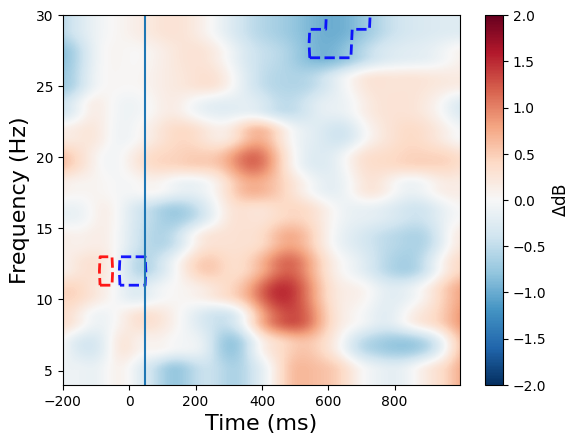

In [17]:
freqs = np.arange(4, 32, 2)
times = np.arange(-200, 1000, 4)
plot_tfr_diff_results(tfr_first_No50, tfr_rep_No50, freqs, times,
                      p=0.05, clusterp=0.05, clim=[-2, 2])